In [442]:
import numpy as np
import matplotlib.pyplot as plt


class Game:
    def __init__ (self, n_patients=4, n_enf=3):
        self.n_patients=n_patients
        self.n_enf=n_enf
        self.reset_patients(self.n_patients)
        
    def reset_patients (self, n_patients, p_short_stay=0.5):
        ''' Inicializa los pacientes que llegan al hospital y su tiempo de estancia
        Parametros:
            n_patients: numero de pacientes que llegan al hospital
            p_short: probabilidad de que un paciente sea de corta estancia
        '''
        stay_length=lambda kind: 1 if kind=='short' else 6
        self.patient_kind_stay=np.random.choice(['short','long'],p=[p_short_stay,1-p_short_stay],size=n_patients)
        self.patient_time_stay=np.vectorize(stay_length)(self.patient_kind_stay)

    def funcion_acciones (self,assignment):
        try:
            enf=np.random.choice(['acepta','rechaza'],p=[0.1,0.9],size=self.n_enf).tolist().index('acepta')
            return enf, True
        except ValueError:
            enf=assignment.astype(bool).sum(axis=1).argmin()
            return enf, False
    
    def run_exp (self, max_ticks=100):

        assignment=np.zeros((self.n_enf,self.n_patients)) 
        u_time, u_penal = np.zeros((max_ticks, self.n_enf)), np.zeros((max_ticks, self.n_enf))
        tick=0; patient=0; last_leave_time=0

        while patient<self.n_patients and tick<max_ticks:

            # Cuando sale el paciente
            patient_leave_time=tick+self.patient_time_stay[patient]

            # Cuando sale el ultimo paciente
            last_leave_time=max(last_leave_time,patient_leave_time)

            # ¿A qué enfermera se le asigna?
            enf, voluntario=self.funcion_acciones(assignment)

            # Si ninguna enfermera acepta, se asigna a la que menos pacientes tenga
            if not voluntario: u_penal[tick:patient_leave_time+1,enf]=1

            # actualizar la ocupacion/pago de las enfermeras
            assignment[enf,patient]=patient_leave_time
            u_time[tick:patient_leave_time+1,enf]+=1 
            assignment[assignment<=tick]=0 # eliminar a los pacientes que ya se han ido

            # avanzar en el tiempo hasta la siguiente llegada
            tick += (1 + int(np.random.exponential(15)))
            patient+=1
        
        return self.fix_utilities(u_time,u_penal,last_leave_time)

    def fix_utilities(self,u_time,u_penal,last_leave_time):
        u = u_time * [0.1,0.2,0.3] + u_penal * [0.3,0.2,0.1]
        return u[:last_leave_time+1,:]
    
    def plot_pagos(self,u):
        fig=plt.figure(figsize=(10,3))
        plt.plot(u, marker='o',markersize=3,linestyle=':')
        fig.legend(['U_%i'%i for i in range(u.shape[0])],bbox_to_anchor=(1,1.04),ncol=u.shape[0])
        plt.title('funcion de pagos de los agentes')
        plt.xlabel('tiempo'); plt.ylabel('utilidad')
        fig.tight_layout()
        return fig


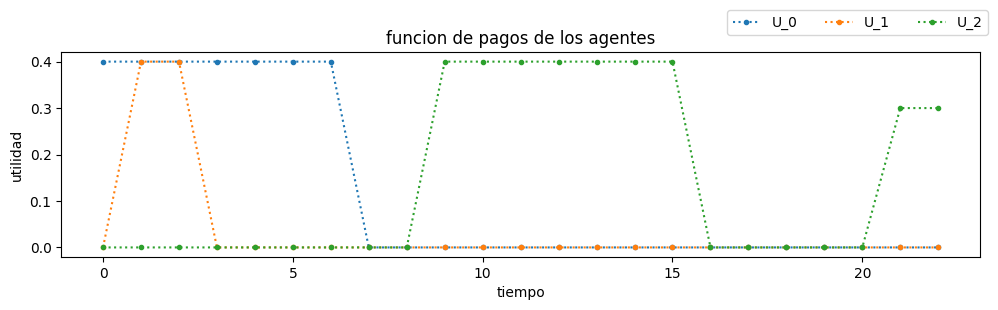

In [447]:
game = Game(n_patients=4, n_enf=3)
u_0 = game.run_exp(max_ticks=100)
_ = game.plot_pagos(u_0)